In [1]:
################################
# Basic layout of the notebook #
################################
#
# 1. Load all prerequisites
# 2. Create a noise generator which outputs noise parameterized by some vars.
# 3. Create an adversary which creates adversarial images according to this noise generator.
# 4. Write a loop to display a few images (real image, regular noise, adversarial)
#
# (Unused)
# 4a. Write a loop to display a few images (real image, regular noise, adv 1, 3, 10 steps.)
# 4b. Write a function to display the averages (real image, regular noise, adv 1, 3, 10 steps.)

#########################################
# Basic layout of the problem statement #
#########################################
#
# 1. You have an image x.
# 2. You can modifiy x by adding adversarial noise to x.
# 2a. There are restrictions on the parameterization of the adversarial noise
# 2b. There are restrictions on the scale of the adversarial noise (?)


In [2]:
!pip install scikit-image

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as trn
import skimage as sk
import cv2

%matplotlib inline

In [13]:
test_transform = trn.Compose([trn.Resize(256), trn.CenterCrop(224), trn.ToTensor()])

mean = torch.FloatTensor(np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1))
std = torch.FloatTensor(np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1))

test_data = dset.ImageFolder('/Users/akommula2/Downloads/imagenette2/val/', transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,
                                          num_workers=1, pin_memory=True)

In [14]:
def remove_module(state_dict):
    d = {}
    for key in state_dict:
        d[key[7:]] = state_dict[key]
    return d

net = models.resnet50()
'''
net.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth',
                                       model_dir='/home/hendrycks/datasets/models'))
'''
session = torch.load('/Users/akommula2/Downloads/deepaugment_and_augmix.pth.tar', map_location=torch.device('cpu'))
state_dict = remove_module(session['state_dict'])
net.load_state_dict(state_dict)
#'''
net.eval()
cudnn.benchmark = True  # fire on all cylinders

In [15]:
to_np = lambda z: z.to('cpu').detach().numpy()

In [16]:
import math
import numbers
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

# modification of code from pytorch forums
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
    """
    def __init__(self, kernel_size, sigma, channels=1):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * 2
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * 2

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        self.conv = F.conv2d

    def forward(self, input, padding=0):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups, padding=padding)


def weighted_line(r0, c0, r1, c1, w, rmin=0, rmax=np.inf):
    if abs(c1-c0) < abs(r1-r0):
        xx, yy, val = weighted_line(c0, r0, c1, r1, w, rmin=rmin, rmax=rmax)
        return (yy, xx, val)

    if c0 > c1:
        return weighted_line(r1, c1, r0, c0, w, rmin=rmin, rmax=rmax)

    slope = (r1-r0) / (c1-c0)
    w *= np.sqrt(1+np.abs(slope)) / 2

    x = np.arange(c0, c1+1, dtype=float)
    y = x * slope + (c1*r0-c0*r1) / (c1-c0)

    thickness = np.ceil(w/2)
    yy = (np.floor(y).reshape(-1,1) + np.arange(-thickness-1,thickness+2).reshape(1,-1))
    xx = np.repeat(x, yy.shape[1])
    vals = trapez(yy, y.reshape(-1,1), w).flatten()

    yy = yy.flatten()
    mask = np.logical_and.reduce((yy >= rmin, yy < rmax, vals > 0))

    return (yy[mask].astype(int), xx[mask].astype(int), vals[mask])

def trapez(y,y0,w):
    return np.clip(np.minimum(y+1+w/2-y0, -y+1+w/2+y0),0,1)

def make_kernels(snow_length_bound=13, blur=True):
    kernels = []

    flip = np.random.uniform() < 0.5

    for i in range(7):
        k_size = snow_length_bound
        mid = k_size//2
        k_npy = np.zeros((k_size, k_size))
        rr, cc, val = weighted_line(
            mid, mid, np.random.randint(mid+2,k_size), np.random.randint(mid+2,k_size),
            np.random.choice([1,3,5], p=[0.6, 0.3, 0.1]), mid, k_size)

        k_npy[rr, cc] = val
        k_npy[:mid+1, :mid+1] = k_npy[::-1,::-1][:mid+1,:mid+1]

        if flip:
            k_npy = k_npy[:, ::-1]

        kernel = torch.FloatTensor(k_npy.copy()).view(1,1,k_size,k_size)

        if blur:
            blurriness = np.random.uniform(0.41, 0.6)
            gaussian_blur = GaussianSmoothing(int(np.ceil(5 * blurriness)), blurriness)
            kernel = gaussian_blur(kernel, padding=1)
        kernels.append(kernel)

    return kernels

def snow_creator(intensities, k, resol):
    flake_grids = []
    k = torch.cat(k, 1)

    intensities_pow = torch.pow(intensities, 4)
    flake_grids = torch.zeros((intensities.size(0), k.size(1), resol, resol))

    for i in range(4):
        flake_grids[:, i, ::4,i::4] = intensities_pow[:,i]
    for i in range(3):
        flake_grids[:, i+4, i+1::4,::4] = intensities_pow[:,4+i]

    snow = F.conv2d(flake_grids, k, padding=k.size(-1)//2)

    return snow

def apply_snow(img, snow, scale, discolor=0.25):    
    out = (1 - discolor) * img +\
    discolor * torch.max(img, (0.2126 * img[:,0:1] + 0.7152 * img[:,1:2] + 0.0722 * img[:,2:3]) * 1.5 + 0.5)   
    return torch.clamp(out + scale[:, None, None, None] * snow, 0, 1)

In [17]:
def add_images(orig_img, snow_noise, noise_scale):    
    return (orig_img + noise_scale * (1.00 - snow_noise))

In [18]:
class SnowAdversary(nn.Module):
    def __init__(self, eps=0.05, img_noise = 0.5, resol = 224, scale=1, num_steps=10, step_size=0.01, budget = 0.2):
        super().__init__()
        self.eps = eps
        self.img_noise = img_noise
        self.resol = resol
        self.scale = scale
        self.num_steps = num_steps
        self.step_size = step_size
        self.budget = budget

    def forward(self, model, bx, by, x_max):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        print (bx.size(0))
        batch_size = bx.size(0)
        rand = torch.rand(bx.size()[0], device='cpu')
        print (batch_size,7,self.resol//4,self.resol//4)
    
        flake_intensities = torch.exp(-1./(self.budget)*torch.rand(batch_size,7,self.resol//4,self.resol//4))
        flake_intensities.requires_grad_(True)
        
        # create initial variables
        snow_vars = [flake_intensities]
        snow_vars[0].requires_grad_()
        
        kernels = make_kernels()
        snow_noise = snow_creator(snow_vars[0], kernels, self.resol)
        adv_bx = apply_snow(bx.detach() / 255.0, snow_noise, rand.mul(self.eps) * 255)
        
        plt.imshow(to_np(adv_bx).squeeze().transpose((1,2,0)))
        plt.show()
        
        # begin optimizing the inner loop

        #'''
        for i in range(self.num_steps):
            opt = optim.Adam(snow_vars, lr=0.03) # Pretty hacky!
            opt.zero_grad()

            with torch.enable_grad():
                snow_noise = snow_creator(snow_vars[0], kernels, self.resol)
                adv_bx = apply_snow(bx.detach() / 255.0, snow_noise, rand.mul(self.eps) * 255)
                
                logits = model((add_images(bx, adv_bx, self.img_noise)/x_max - mean)/std)
                loss = -F.cross_entropy(logits, by, reduction='sum')
                print ("CURRENT LOSS:", -to_np(loss))
            
            loss.backward(retain_graph=True)
            opt.step()
            
            # clamp variables
            snow_vars[0] = snow_vars[0].detach()
            snow_vars[0] = snow_vars[0].clone().clamp(1e-9, 1)
            snow_vars[0].requires_grad_()
            #print(brightness_vars[0].mean())
            
        snow_noise = snow_creator(snow_vars[0], kernels, self.resol)
        adv_bx = apply_snow(bx.detach() / 255.0, snow_noise, rand.mul(self.eps) * 255)
        #'''
        return adv_bx

In [19]:
scale = 0.05
eps = 0.05
img_noise = 0.5


Clean Image
Loss: 11.384544
Wrong Prediction


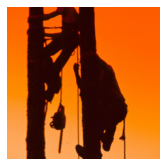


Adversarial Template
1
1 7 56 56


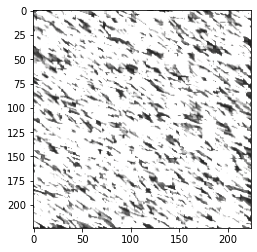

CURRENT LOSS: 10.483887
CURRENT LOSS: 14.61524
CURRENT LOSS: 18.941656
CURRENT LOSS: 22.836401
CURRENT LOSS: 25.454683
CURRENT LOSS: 27.877213
CURRENT LOSS: 29.728252
CURRENT LOSS: 31.098764
CURRENT LOSS: 32.65352
CURRENT LOSS: 33.61814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 34.767162
Wrong Prediction


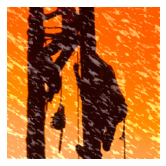

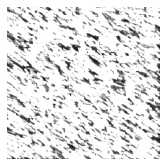


Clean Image
Loss: 15.69974
Wrong Prediction


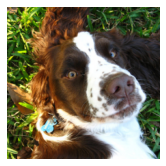


Adversarial Template
1
1 7 56 56


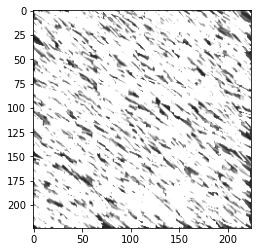

CURRENT LOSS: 16.845535
CURRENT LOSS: 21.75576
CURRENT LOSS: 24.991766
CURRENT LOSS: 27.712856
CURRENT LOSS: 29.123735
CURRENT LOSS: 30.626497
CURRENT LOSS: 31.679249
CURRENT LOSS: 31.743973
CURRENT LOSS: 33.237106
CURRENT LOSS: 32.801117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 34.08946
Wrong Prediction


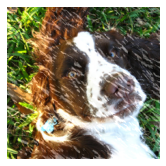

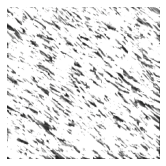


Clean Image
Loss: 18.088398
Wrong Prediction


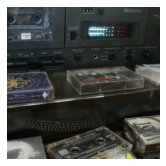


Adversarial Template
1
1 7 56 56


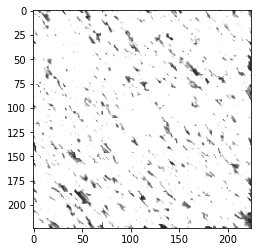

CURRENT LOSS: 14.422703
CURRENT LOSS: 19.051495
CURRENT LOSS: 22.147295
CURRENT LOSS: 24.202864
CURRENT LOSS: 25.807049
CURRENT LOSS: 27.440374
CURRENT LOSS: 28.22409
CURRENT LOSS: 29.471323
CURRENT LOSS: 30.595957
CURRENT LOSS: 31.484337


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 32.203403
Wrong Prediction


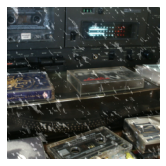

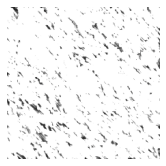

In [20]:
for i, (x, label) in enumerate(test_loader):
    if i < 3:
        adv = SnowAdversary(eps=eps, img_noise = img_noise, scale=scale)
    
        print('\nClean Image')
        target = torch.LongTensor([label])

        x_max, _ = torch.max(x.view(x.size(0), 3, -1), -1)
        x_max = x_max.view(-1, 3, 1, 1)

        logits = net((x - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1) # induced for comparable size
        plt.imshow(to_np(x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        print('\nAdversarial Template')

        adv_x = adv(net, x, target, x_max)
        
        logits = net(((add_images(x, adv_x, img_noise))/x_max - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1)
        plt.imshow(to_np(add_images(x, adv_x, img_noise)).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        plt.subplot(1,2,1)
        plt.imshow(to_np(adv_x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()
        
    else:
        break